In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd

In [21]:
df = pd.read_csv("long_data_.csv")
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [22]:
# Convert 'Dates' column to datetime format
df["ds"] = pd.to_datetime(df["Dates"], format="%d/%m/%Y %H:%M:%S")

In [23]:
# Rename columns
df.rename(columns={"States": "unique_id", "Usage": "y"}, inplace=True)

In [ ]:
# Keep only relevant columns
demand_df = df[["unique_id", "ds", "y"]].sort_values(["unique_id", "ds"]).reset_index(drop=True)


In [24]:
# Show sample
demand_df.head()

,unique_id,ds,y
0,Andhra Pradesh,2019-01-02,164.6
1,Andhra Pradesh,2019-01-03,170.1
2,Andhra Pradesh,2019-01-04,165.2
3,Andhra Pradesh,2019-01-05,167.4
4,Andhra Pradesh,2019-01-06,171.2


In [25]:
# Save the processed dataset
demand_df.to_csv("indian_electricity_demand.csv", index=False)


In [20]:
from google.colab import files
files.download("indian_electricity_demand.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
%pip install --upgrade pip
%pip install nixtla utilsforecast mlforecast lightgbm scikit-learn pandas matplotlib


In [27]:
import os
from nixtla import NixtlaClient
import pandas as pd

os.environ['NIXTLA_API_KEY'] = 'nixak-JCA5ab7YJEHMivpmUlwl8NXhv8JgkglnSgEDCI4GWsTFKQtpQNr4TMDLWeedQZPEybgVp7t8O6PMXG0x'
nixtla_client = NixtlaClient(api_key=os.environ['NIXTLA_API_KEY'])

print("✅ Nixtla client created successfully.")


✅ Nixtla client created successfully.


In [28]:
df = pd.read_csv('/content/indian_electricity_demand.csv')
df = df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds'])

df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

df = df.drop_duplicates(subset=['unique_id', 'ds']).sort_values(['unique_id', 'ds'])

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 16434 entries, 0 to 16598
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  16434 non-null  object        
 1   ds         16434 non-null  datetime64[ns]
 2   y          16434 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 513.6+ KB
None
        unique_id         ds      y
0  Andhra Pradesh 2019-01-02  164.6
1  Andhra Pradesh 2019-01-03  170.1
2  Andhra Pradesh 2019-01-04  165.2
3  Andhra Pradesh 2019-01-05  167.4
4  Andhra Pradesh 2019-01-06  171.2


In [29]:
filled_dfs = []

for uid, group in df.groupby('unique_id'):
    group = group.set_index('ds').asfreq('D')
    group['unique_id'] = uid
    group['y'] = group['y'].interpolate()
    filled_dfs.append(group.reset_index())

df = pd.concat(filled_dfs)

print("✅ Missing dates filled and values interpolated.")
print(df.head())


✅ Missing dates filled and values interpolated.
          ds       unique_id      y
0 2019-01-02  Andhra Pradesh  164.6
1 2019-01-03  Andhra Pradesh  170.1
2 2019-01-04  Andhra Pradesh  165.2
3 2019-01-05  Andhra Pradesh  167.4
4 2019-01-06  Andhra Pradesh  171.2


In [30]:
anomalies_df = nixtla_client.detect_anomalies(
    df,
    time_col='ds',
    target_col='y',
    freq='D'
)
anomalies_df[anomalies_df['anomaly'] == 1].head()


,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
18,Andhra Pradesh,2019-02-21,197.0,153.24968,193.21740,113.281960,True
19,Andhra Pradesh,2019-02-22,201.0,152.88773,192.85545,112.920006,True
20,Andhra Pradesh,2019-02-23,197.1,153.06440,193.03214,113.096690,True
200,Andhra Pradesh,2019-08-22,155.9,198.55017,238.51790,158.582440,True
215,Andhra Pradesh,2019-09-06,205.1,163.67169,203.63942,123.703970,True


In [32]:
h = 200  # forecast horizon

# Split train/test by last h days per state
test_df = df.groupby('unique_id').tail(h)
train_df = df.groupby('unique_id').apply(lambda g: g.iloc[:-h]).reset_index(drop=True)

# Forecast
predict_df = nixtla_client.forecast(
    df=train_df,
    h=h,
    level=[90],
    finetune_steps=1000,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    freq='D'
)

print("✅ Forecast completed for all states.")
predict_df.head()


/tmp/ipython-input-3435119806.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda g: g.iloc[:-h]).reset_index(drop=True)
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out


✅ Forecast completed for all states.


,unique_id,ds,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
0,Andhra Pradesh,2020-05-20,186.12404,189.63158,182.61650
1,Andhra Pradesh,2020-05-21,185.63109,189.03706,182.22511
2,Andhra Pradesh,2020-05-22,184.86118,188.99379,180.72856
3,Andhra Pradesh,2020-05-23,184.18420,188.39856,179.96985
4,Andhra Pradesh,2020-05-24,185.03421,189.26718,180.80124


In [33]:
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

predict_df['ds'] = pd.to_datetime(predict_df['ds'])
merged = pd.merge(test_df, predict_df, 'left', ['ds', 'unique_id'])

evaluation = evaluate(
    merged,
    metrics=[mae, rmse, smape],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)
avg_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
print("📊 Average metrics across states:")
print(avg_metrics)


📊 Average metrics across states:
metric
mae      16.419667
rmse     20.277138
smape     0.074567
Name: TimeGPT, dtype: float64


In [34]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_features(data, lags=[1,2,3,7]):
    df_feat = data.copy().sort_values(['unique_id','ds'])
    df_feat['dayofweek'] = df_feat['ds'].dt.dayofweek
    df_feat['month'] = df_feat['ds'].dt.month
    df_feat['day'] = df_feat['ds'].dt.day
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat.groupby('unique_id')['y'].shift(lag)
    df_feat['roll_mean_7'] = df_feat.groupby('unique_id')['y'].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
    return df_feat

train_feat = create_features(train_df)
test_feat = create_features(pd.concat([train_df, test_df]))
test_feat = test_feat[test_feat['ds'].isin(test_df['ds'])]
train_feat = train_feat.dropna()
test_feat = test_feat.dropna()

features = ['lag_1','lag_2','lag_3','lag_7','dayofweek','month','day','roll_mean_7']

preds_list = []
for uid in df['unique_id'].unique():
    X_train = train_feat[train_feat['unique_id']==uid][features]
    y_train = train_feat[train_feat['unique_id']==uid]['y']
    X_test = test_feat[test_feat['unique_id']==uid][features]
    y_test = test_feat[test_feat['unique_id']==uid]['y']

    X_train = X_train.replace([np.inf,-np.inf],np.nan).fillna(0)
    X_test = X_test.replace([np.inf,-np.inf],np.nan).fillna(0)

    if len(y_train)>20:
        model = LGBMRegressor(random_state=42, n_estimators=200, verbose=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        temp = test_feat[test_feat['unique_id']==uid][['unique_id','ds','y']].copy()
        temp['LGBM'] = y_pred
        preds_list.append(temp)

lgbm_pred_df = pd.concat(preds_list)


In [35]:
comparison_df = lgbm_pred_df.merge(predict_df[['unique_id','ds','TimeGPT']], on=['unique_id','ds'], how='left')

def smape_func(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

results = []
for uid, g in comparison_df.groupby('unique_id'):
    mae_lgbm = mean_absolute_error(g['y'], g['LGBM'])
    rmse_lgbm = np.sqrt(mean_squared_error(g['y'], g['LGBM']))
    smape_lgbm = smape_func(g['y'], g['LGBM'])

    mae_tgpt = mean_absolute_error(g['y'], g['TimeGPT'])
    rmse_tgpt = np.sqrt(mean_squared_error(g['y'], g['TimeGPT']))
    smape_tgpt = smape_func(g['y'], g['TimeGPT'])

    results.append([uid, mae_lgbm, rmse_lgbm, smape_lgbm, mae_tgpt, rmse_tgpt, smape_tgpt])

results_df = pd.DataFrame(results, columns=[
    'unique_id','LGBM_MAE','LGBM_RMSE','LGBM_SMAPE',
    'TimeGPT_MAE','TimeGPT_RMSE','TimeGPT_SMAPE'
])

print("📈 Average performance comparison:")
print(results_df.mean(numeric_only=True))


📈 Average performance comparison:
LGBM_MAE          9.351507
LGBM_RMSE        12.019529
LGBM_SMAPE        9.393875
TimeGPT_MAE      16.419667
TimeGPT_RMSE     20.277138
TimeGPT_SMAPE    14.913449
dtype: float64


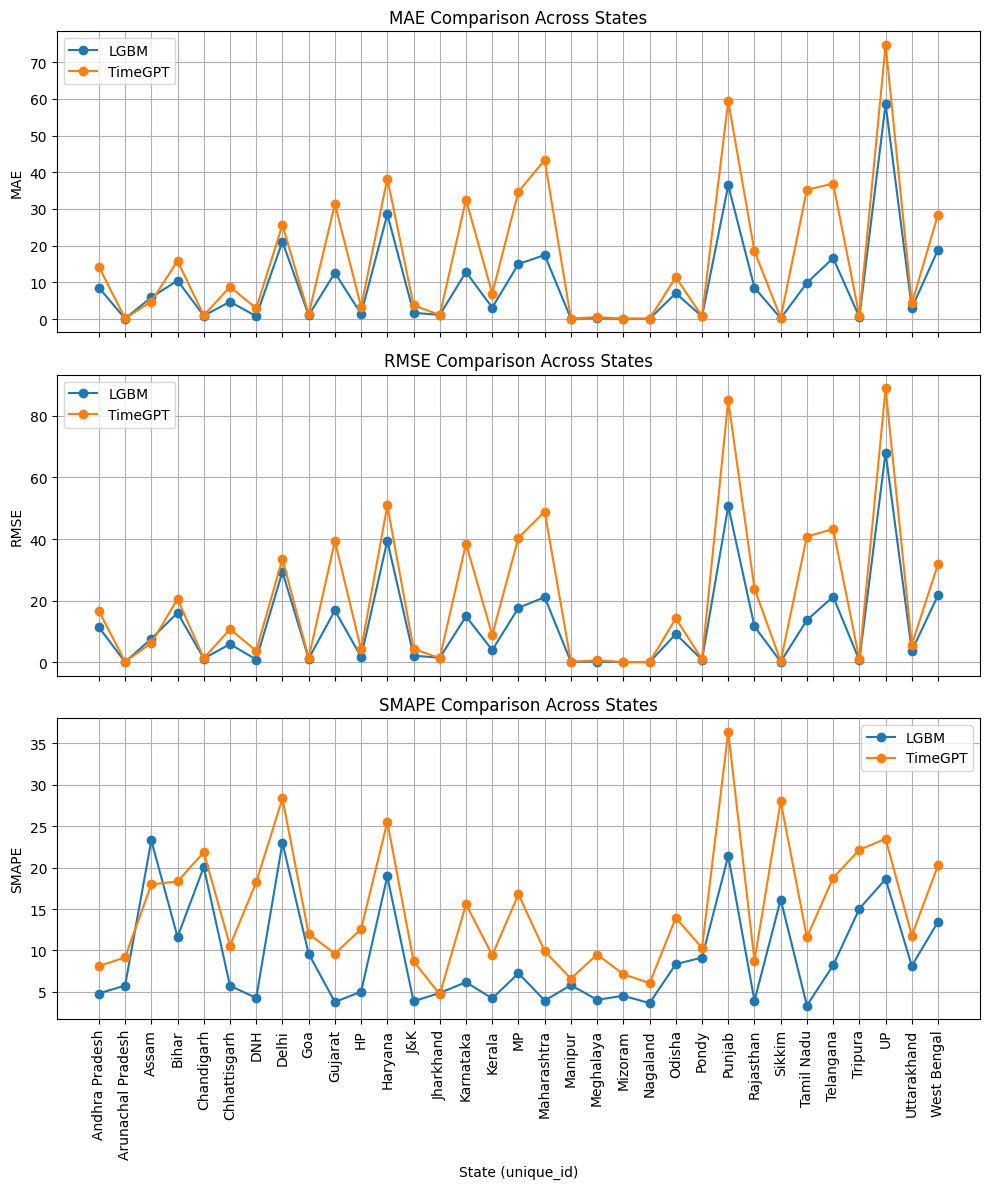

In [36]:
import matplotlib.pyplot as plt

plot_df = results_df.melt(
    id_vars='unique_id',
    value_vars=['LGBM_MAE','TimeGPT_MAE','LGBM_RMSE','TimeGPT_RMSE','LGBM_SMAPE','TimeGPT_SMAPE'],
    var_name='Model_Metric', value_name='Value'
)

plot_df['Model'] = plot_df['Model_Metric'].apply(lambda x: x.split('_')[0])
plot_df['Metric'] = plot_df['Model_Metric'].apply(lambda x: x.split('_')[1])

metrics_to_plot = ['MAE','RMSE','SMAPE']
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 12), sharex=True)

for i, metric in enumerate(metrics_to_plot):
    metric_df = plot_df[plot_df['Metric']==metric]
    for model in metric_df['Model'].unique():
        model_df = metric_df[metric_df['Model']==model]
        axes[i].plot(model_df['unique_id'], model_df['Value'], marker='o', label=model)
    axes[i].set_title(f'{metric} Comparison Across States')
    axes[i].set_ylabel(metric)
    axes[i].grid(True)
    axes[i].legend()

axes[-1].set_xlabel('State (unique_id)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/tmp/ipython-input-576881462.py:40: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-576881462.py:40: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


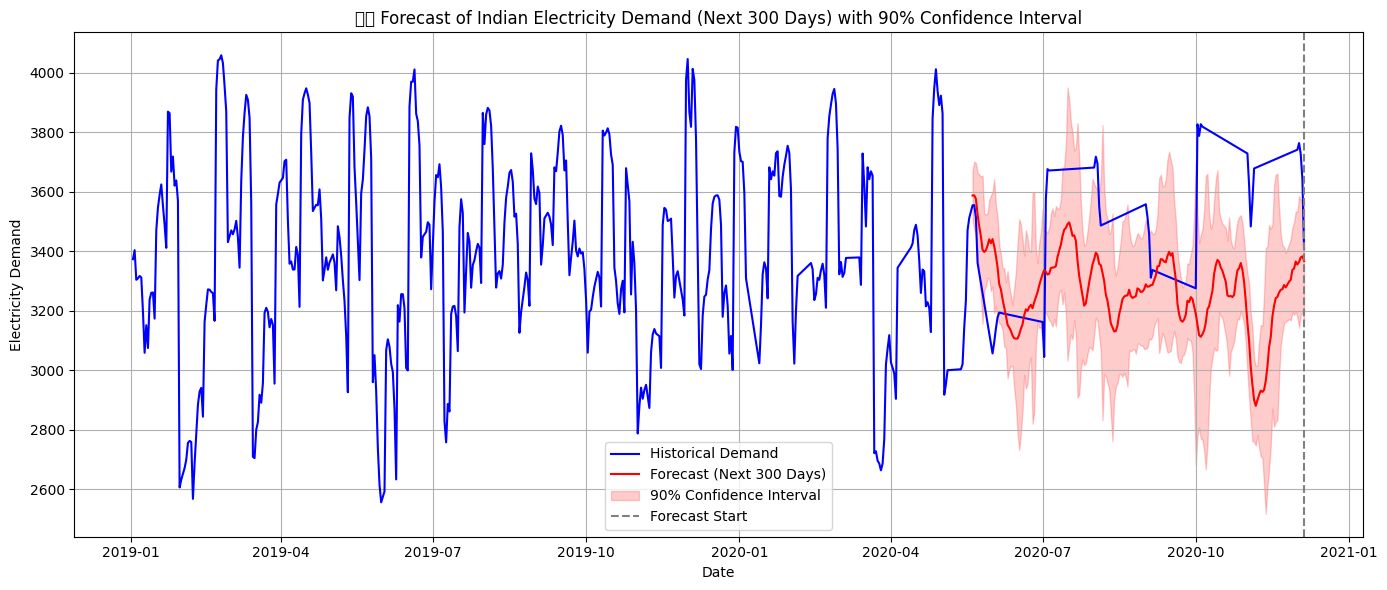

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate total demand across all states
india_actual = df.groupby('ds')['y'].sum().reset_index()
india_forecast = (
    predict_df.groupby('ds')
    .agg({'TimeGPT': 'sum', 'TimeGPT-lo-90': 'sum', 'TimeGPT-hi-90': 'sum'})
    .reset_index()
)

# Plot
plt.figure(figsize=(14, 6))

# Historical demand
plt.plot(india_actual['ds'], india_actual['y'], label='Historical Demand', color='blue')

# Forecast mean
plt.plot(india_forecast['ds'], india_forecast['TimeGPT'], label='Forecast (Next 300 Days)', color='red')

# Confidence interval (shaded area)
plt.fill_between(
    india_forecast['ds'],
    india_forecast['TimeGPT-lo-90'],
    india_forecast['TimeGPT-hi-90'],
    color='red',
    alpha=0.2,
    label='90% Confidence Interval'
)

# Forecast start marker
plt.axvline(india_actual['ds'].max(), color='gray', linestyle='--', label='Forecast Start')

# Labels and title
plt.title('🇮🇳 Forecast of Indian Electricity Demand (Next 300 Days) with 90% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
